# PMT stats

This notebook is meant to show the statistical properties of the PMT waveforms in dark operation. The main functionalities are:

1. Computing the baseline and RMS for each PMT and the PMT sum.
2. Show some monitor plots about these quantities.
3. Write a hdf5 file with the computed RMS values.

In [1]:
from __future__ import print_function
import numpy as np
import tables as tb
%matplotlib inline
import matplotlib.pyplot as plt
import time

import sensorFunctions as sns

print("This notebook has been run last on {} at {}.".format(time.strftime("%d/%m/%Y"),time.strftime("%H:%M:%S")))

This notebook has been run last on 06/11/2016 at 15:14:11.


In [2]:
try:
    h5f.close()
except:
    pass

In [3]:
h5f = tb.open_file("/Users/Gonzalo/github/IC/data/run_2639.h5")
pmtrwf = h5f.root.RD.pmtrwf
pmtdf = sns.read_data_sensors(h5f.root.Sensors.DataPMT)

#### A look to the contents of the file

In [4]:
print(h5f)

/Users/Gonzalo/github/IC/data/run_2639.h5 (File) ''
Last modif.: 'Tue Nov  1 20:21:50 2016'
Object Tree: 
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
/RD (Group) ''
/RD/pmtblr (EArray(0, 12, 48000), shuffle, zlib(4)) ''
/RD/pmtrwf (EArray(1050, 12, 48000), shuffle, zlib(4)) ''
/RD/sipmrwf (EArray(1050, 1792, 1200), shuffle, zlib(4)) ''
/Run (Group) ''
/Run/event_number (EArray(1050,), shuffle, zlib(4)) ''
/Run/runInfo (Table(1,)) ''
/Sensors (Group) ''
/Sensors/DataBLR (Table(12,)) ''
/Sensors/DataPMT (Table(12,)) ''
/Sensors/DataSiPM (Table(1792,)) ''



#### A look to the data related to PMTs

In [5]:
print(pmtdf)

    adc_to_pes  channel     coeff  noise_rms  sensorID           x           y
0   -22.916800        0  0.001652     0.7134         0  -23.941401   65.778503
1   -25.300800        1  0.001631     0.7090         2   68.936501  -12.155400
2   -18.212999        4  0.001611     0.7217        11  118.916000  141.718002
3   -15.855700        5  0.001601     0.7299        10  182.188995   32.124901
4   -33.099300        8  0.001643     0.7362         7  -63.273701 -173.843002
5   -22.134001        9  0.001625     0.7045         6 -160.214996  -92.500000
6   -23.750999       18  0.001632     0.9578         1  -44.995098  -53.623100
7   -25.998400       19  0.001629     0.7726         3   -0.000000  185.000000
8   -25.169800       22  0.001621     0.7404         9  160.214996  -92.500000
9   -20.437700       23  0.001627     0.7339         8   63.273701 -173.843002
10  -20.892700       26  0.001595     0.7908         5 -182.188995   32.124901
11  -23.707399       27  0.001582     0.7348        

#### Some functions for computing the baseline, rms and some monitoring plots

In [6]:
def compute_wf_stats(wf, n_loops=1):
    """
    Compute the baseline and RMS of the waveform recursively
    removing possible signal-like structures.
    
    Parameters
    ----------
    wf : ndarray
        Waveform to which the RMS is computed
    n_loops : int
        Number of recursive steps
        
    Returns
    -------
    mean : float
        Average value of the waveform
    rms : float
        Value of the rms
    """    
    mean = np.mean(wf)
    rms = np.std(wf)
    if n_loops == 0:
        return mean, rms

    masked_wf = np.ma.masked_greater(wf, mean + 3*rms)
    return compute_wf_stats(masked_wf, n_loops-1)


def compute_stats_dataset(evts, sample_size=-1, n_loops=1):
    """
    Analyze a dataset to extract the RMS (noise).
    
    Parameters
    ----------
    evts : ndarray
        Array containing the wf (axis 2) for each sensor (axis 1)
        and event (axis 0).
    sample_size : int
        Size of the sample to be taken for measuring the stats.
    n_loops : int
        Number of loops for the RMS calculation.
        
    Returns
    -------
    sum_bl : ndarray
        Baseline of the PMT sum for each event
    sum_rms : ndarray
        RMS of the PMT sum for each event
    pmt_bl : ndarray
        Baseline for each PMT (axis 0) for each event (axis 1)
    pmt_rms : ndarray
        RMS for each PMT (axis 0) for each event (axis 1)
    """
    compute_stats = lambda x: compute_wf_stats(x, n_loops)
    if sample_size <= 0:
        sample_size = evts.shape[2]
    
    pmt_bl, sum_bl, pmt_rms, sum_rms = [], [], [], []
    for evt in evts:
        samples = evt[:,:sample_size]
        data = zip(*np.apply_along_axis(compute_stats, 1, samples))
        pmt_bl.append(data[0])
        pmt_rms.append(data[1])
        
        data = compute_stats(samples.sum(axis=0))
        sum_bl.append(data[0])
        sum_rms.append(data[1])
    
    return np.array(sum_bl), np.array(sum_rms), np.array(pmt_bl).T, np.array(pmt_rms).T


def control_plots(sum_bl, sum_rms, pmt_bl, pmt_rms, pmtdf, log_scale=False):
    """
    Create control plots to ensure data is valid.
    """
    ###############################################
    ## SUM PLOTS
    ###############################################
    fig, axes = plt.subplots(2)
    fig.set_size_inches(10,6)
    data_bl = sum_bl
    data_rms = sum_rms
    
    low = np.mean(data_bl) - np.std(data_bl)
    upp = np.mean(data_bl) + np.std(data_bl)
    h = axes[0].hist(data_bl, 100, range=(low,upp))
    axes[0].text(low + (upp-low)/1.5, np.max(h[0])/2,
                 '$\mu$ = {:.1f} pes\n$\sigma$ = {:.1f} pes'.format(np.mean(data_bl), np.std(data_bl)))
    axes[0].set_xlabel("Waveform baseline (adc)")
    axes[0].set_ylabel("Entries")
    axes[0].set_title("PMT sum")
    if log_scale:
        axes[0].set_yscale('log')
    
    low = np.min(data_rms)
    upp = np.mean(data_rms) + 0.02*np.std(data_rms)
    h = axes[1].hist(data_rms, 100, range=(low,upp))
    axes[1].text(low + (upp-low)/1.5, np.max(h[0])/2,
                 'mean = {:.4f} pes\npeak = {:.4f} pes'.format(np.mean(data_rms), h[1][np.argmax(h[0])]))
    axes[1].set_xlabel("Waveform RMS (pes)")
    axes[1].set_ylabel("Entries")
    axes[1].set_title("PMT sum")
    if log_scale:
        axes[1].set_yscale('log')
    plt.tight_layout()

    ###############################################
    ## BL PLOTS
    ###############################################
    fig, axes = plt.subplots(4,3)
    axes = axes.flatten()
    fig.set_size_inches(10,8)
    for i, data in enumerate(pmt_bl):
        low = np.mean(data) - 3*np.std(data)
        upp = np.mean(data) + 6*np.std(data)
        # In some cases a weird event makes the plot and the stats
        # look bad. Therefore, a soft selection is made.
        data = data[ (data > low) & (data < upp) ]
        low = np.mean(data) - 3*np.std(data)
        upp = np.mean(data) + 6*np.std(data)

        h = axes[i].hist(data, 100, range=(low,upp))
        if log_scale:
            axes[i].set_yscale('log')
        axes[i].text(low+(upp-low)/2, np.max(h[0])/2,
                     '$\mu$ = {:.1f} pes\n$\sigma$ = {:.1f} pes'.format(np.mean(data), np.std(data)))
        axes[i].set_xlabel("Waveform baseline (adc)")
        axes[i].set_ylabel("Entries")
        axes[i].set_title("PMT " + str(pmtdf['channel'][i]))
    plt.tight_layout()

    ###############################################
    ## RMS PLOTS
    ###############################################
    fig, axes = plt.subplots(4,3)
    axes = axes.flatten()
    fig.set_size_inches(10,8)
    for i, data in enumerate(pmt_rms):
        low = np.min(data)
        upp = np.mean(data) + 0.15*np.std(data)
        h = axes[i].hist(data, 100, range=(low,upp))
        if log_scale:
            axes[i].set_yscale('log')
        axes[i].text(low+(upp-low)/3, np.max(h[0])/2,
                     'mean = {:.4f} adc\npeak = {:.4f} adc'.format(np.mean(data), h[1][np.argmax(h[0])]))
        axes[i].set_xlabel("Waveform RMS (adc)")
        axes[i].set_ylabel("Entries")
        axes[i].set_title("PMT " + str(pmtdf['channel'][i]))
    plt.tight_layout()
    

def create_rms_table(run_file, out_file, window_size=1000, n_loops=1, confirm=True):
    """
    Creates a new file holding the copy of the DataPMT table with the
    noise_rms column modified according to the new computed values.
    """
    with tb.open_file(run_file) as h5in:
        datapmt_in = h5in.root.Sensors.DataPMT
        pmt_wfs = h5in.root.RD.pmtrwf
        pmtdf = sns.read_data_sensors(datapmt_in)
        
        data = compute_stats_dataset(pmt_wfs, window_size, n_loops)
        sum_bl, sum_rms, pmt_bl, pmt_rms = data
        if confirm:
            control_plots(sum_bl, sum_rms, pmt_bl, pmt_rms, pmtdf)
            confirmation = raw_input("Confirm (y/[n]): ")
            if confirmation == "y":
                print("Writing noise_rms constants to", out_file)
            else:
                print("Aborted")
        with tb.open_file(out_file,"w") as h5out:
            datapmt_out = datapmt_in.copy(newparent=h5out.root)
            datapmt_out.cols.noise_rms[:] = pmt_rms
            datapmt_out.flush()

## Histograms of the baselines and RMS for each PMT and for the sum

In [7]:
sum_bl, sum_rms, pmt_bl, pmt_rms = compute_stats_dataset(pmtrwf, -1, 0)

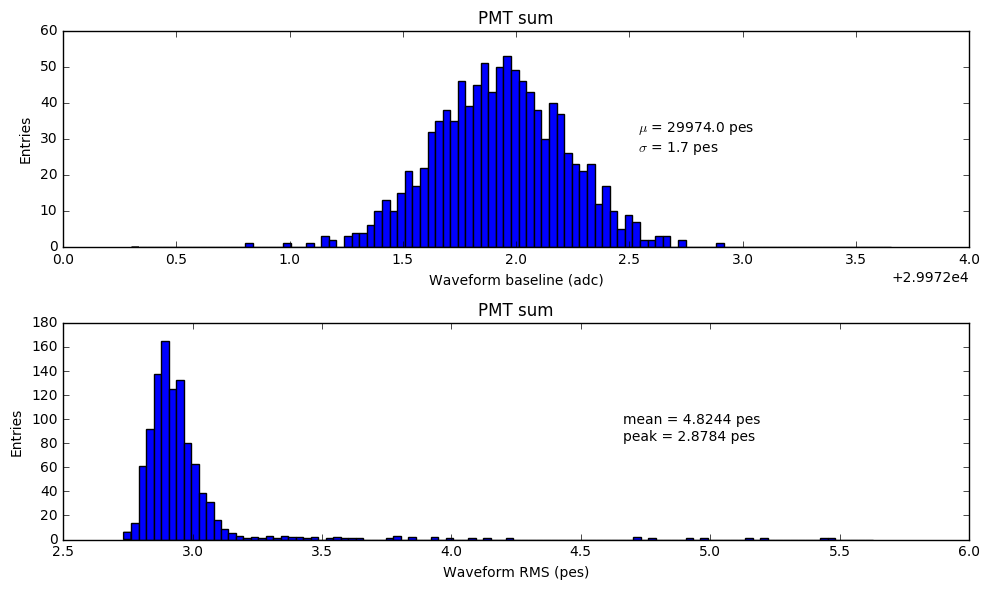

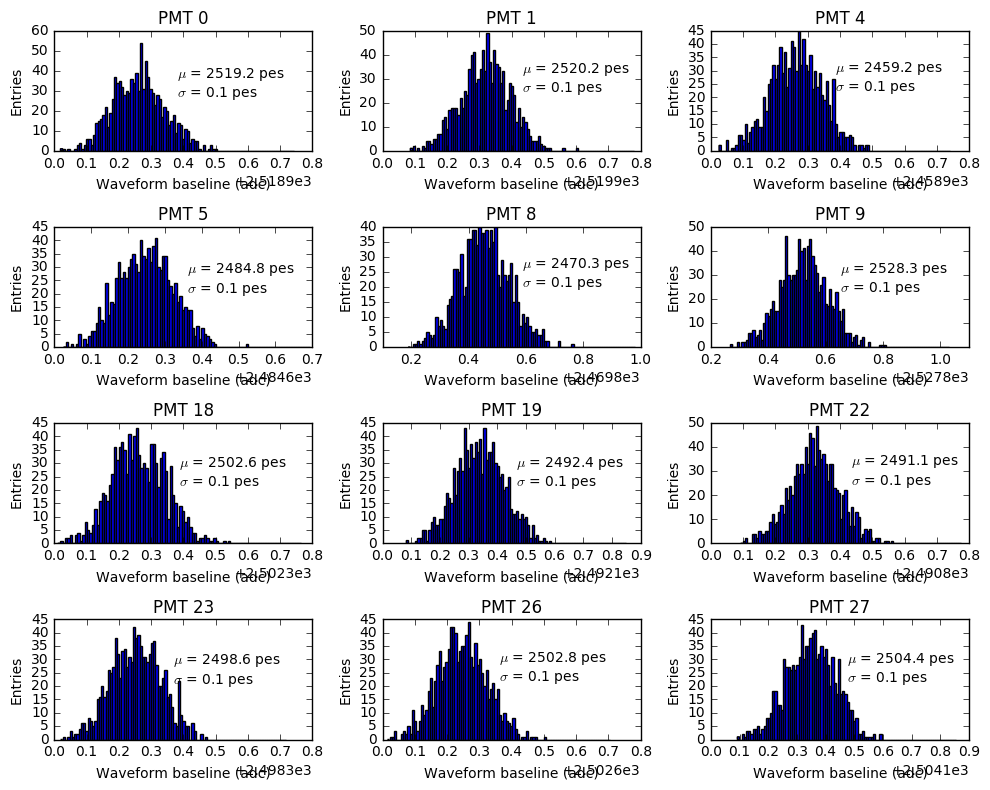

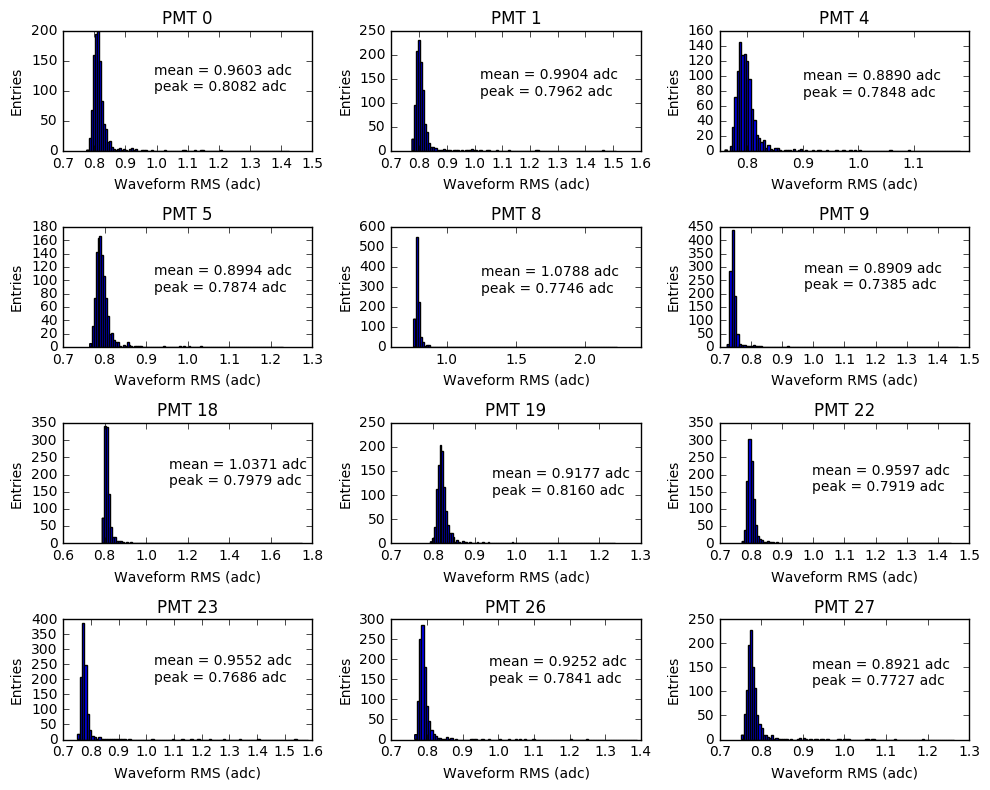

In [8]:
control_plots(sum_bl, sum_rms, pmt_bl, pmt_rms, pmtdf)

# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------

### A plot of the RMS vs the event
In some cases there is signal-like structures in the waveform.

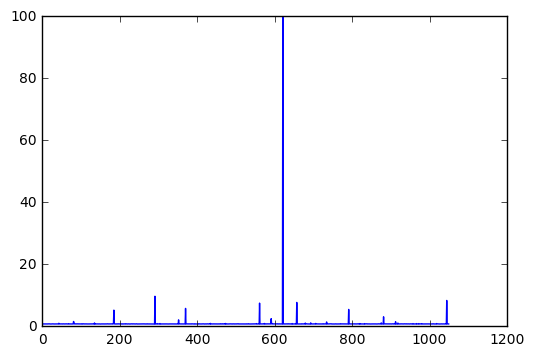

In [9]:
plt.plot(pmt_rms[0])

#### A case where a signal like event disturbs the RMS.

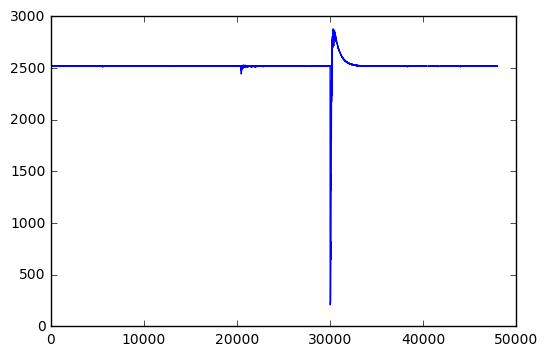

In [10]:
plt.plot(pmtrwf[621][0])
#plt.xlim((29000,33000))

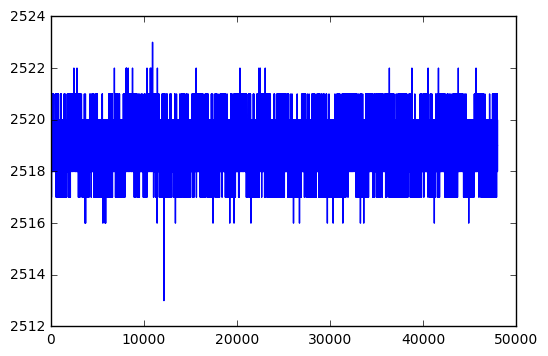

In [11]:
plt.plot(pmtrwf[0][0])